In [130]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import pydicom
import cv2
import keras
from keras.applications.vgg16 import preprocess_input

In [59]:
train_path = '/kaggle/input/siim-dicom-images/siim-original/dicom-images-train'
rle_path = '/kaggle/input/siim-dicom-images/train-rle.csv'

train_filenames = os.listdir(train_path)
rle_csv = pd.read_csv(rle_path)

In [60]:
print('Length of data = ', len(train_filenames))

rle_csv.head()

Length of data =  10712


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [118]:
def process_labels(df): #Converts labels to binary
    
    labels = df[" EncodedPixels"].to_list()
    a = []
    for i in labels:
      if i == ' -1':
        a.append(0)
      else: a.append(1)
    df["Class"] = np.array(a, dtype='uint8')
    return df

def add_full_path(df, train_path):
    my_glob = glob(train_path + '/*/*/*.dcm')

    full_img_paths = {os.path.basename(x).split('.dcm')[0]: x for x in my_glob}
    dataset_path = df['ImageId'].map(full_img_paths.get)
    
    df['full_path'] = dataset_path
    
    return df


def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    if rle == ' -1':
        rle ='0 0'
    
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [63]:
rle_csv = process_labels(rle_csv)
rle_csv = add_full_path(rle_csv, train_path)

rle_csv.head()

,ImageId,EncodedPixels,Class,full_path
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,0,/kaggle/input/siim-dicom-images/siim-original/...
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0,/kaggle/input/siim-dicom-images/siim-original/...
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1,/kaggle/input/siim-dicom-images/siim-original/...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,1,/kaggle/input/siim-dicom-images/siim-original/...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,1,/kaggle/input/siim-dicom-images/siim-original/...


image shape =  (1024, 1024)


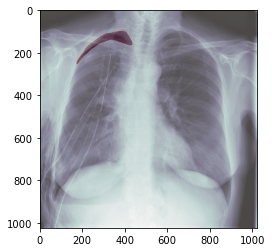

In [129]:
ID = 2

img = pydicom.dcmread(rle_csv['full_path'][ID]).pixel_array
mask = rle2mask(rle_csv[' EncodedPixels'][ID], *img.shape).T

print('image shape = ', img.shape)

plt.imshow(img, cmap = plt.cm.bone)
plt.imshow(mask, alpha=0.3, cmap='Reds')

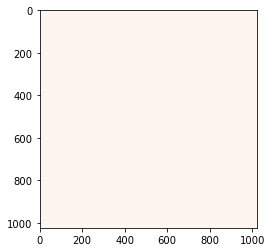

In [103]:
plt.imshow(rle2mask('0 0', 1024,1024).T, cmap='Reds')

In [204]:
class Seg_gen(keras.utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self, df, preprocess_fct, batch_size=32, dim=(1024, 1024), shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.df = df
        self.n = len(df)            
        self.nb_iteration = int(np.floor(self.n  / self.batch_size))
        
        self.on_epoch_end()
                    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
   
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size, *self.dim))
        
        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img  = pydicom.dcmread(self.df['full_path'][ID]).pixel_array
            mask = rle2mask(self.df[' EncodedPixels'][ID], *img.shape).T/255           
                                                                                
            img  = np.asarray(cv2.resize(img, self.dim))
            mask = np.asarray(cv2.resize(mask, self.dim))            
            
            X[i,] = np.asarray(img)#self.preprocess_fct(np.asarray(img))
            Y[i,] = np.asarray(mask)
        
        return X, Y 

In [226]:
x,y = next(iter(Seg_gen(rle_csv, preprocess_input, batch_size = 32, dim=(256,256))))

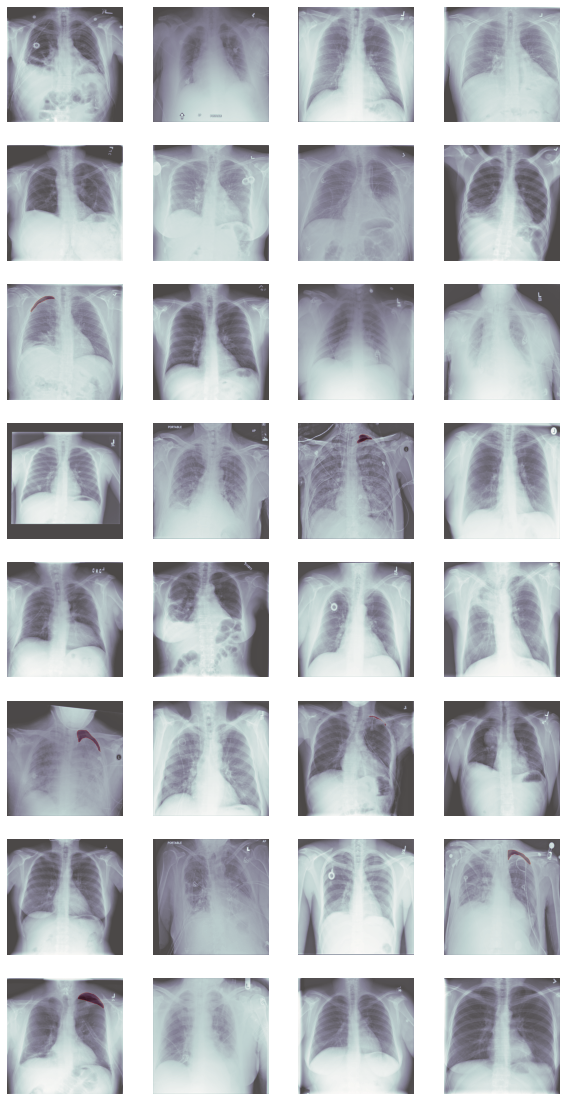

In [227]:
row=8
index=0
fig, axs = plt.subplots(row, len(x)//row, sharey=True, figsize = (10,20))
for i in range(row):
    for j in range (len(x)//row):
      axs[i][j].imshow(x[index], cmap = plt.cm.bone)
      axs[i][j].imshow(y[index], alpha=0.3, cmap='Reds')  
      axs[i][j].axis('off')
      index = index + 1